### Author: **Dimitrios Yfantidis (3938)**
_Written in Python ver. 3.10.7_

In [1]:
# Initialization
import os
import pickle
import numpy as np

from time import perf_counter as timer

# It is imperative that all cells are executed in order

(Elapsed: 0.1s)

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 mutually exclusive classes, with 6000 images per class.  
There are 50000 training images and 10000 test images.  

The archive contains the files `data_batch_1`, `data_batch_2`, ..., `data_batch_5`, as well as `test_batch`.  
Each of these files is a Python "pickled" object produced with cPickle. They can be retrieved using the following function:

In [2]:
def unpickle(file: str) -> dict:
    with open(file, 'rb') as fo:
        dictionary = pickle.load(fo, encoding='bytes')
    return dictionary

(Elapsed: 0.0s)

We will now proceed to retrieve the entire dataset.

In [3]:
# The folder, relative to the working directory, that contains the data.
data_dir = 'cifar-10-batches-py'
# The filenames of the 5 batches (as list).
batch_files = [os.path.join(data_dir, 'data_batch_' + str(n)) for n in range(1, 6)]
# The names of the ten classes (as list).
class_names = unpickle(os.path.join(data_dir, 'batches.meta'))[b'label_names']
print(f'{len(class_names)} classes:')
for name in class_names:
    print(f'- {name}')
# The 5 training batches (as list) and the test batch.
training_batches = []
for file in batch_files:
    training_batches.append(unpickle(file))
test_batch = unpickle(os.path.join(data_dir, 'test_batch'))

print('Working directory: \"%s\"' % (data_dir))
print('Batch filenames:')
for filename in batch_files:
    print('- %s' % (filename))
print('Retrieved training batches:')
for batch in training_batches:
    print('- %s' % (batch[b'batch_label']))
print('Retrieved test batch: %s' % (test_batch[b'batch_label']))

10 classes:
- b'airplane'
- b'automobile'
- b'bird'
- b'cat'
- b'deer'
- b'dog'
- b'frog'
- b'horse'
- b'ship'
- b'truck'
Working directory: "cifar-10-batches-py"
Batch filenames:
- cifar-10-batches-py\data_batch_1
- cifar-10-batches-py\data_batch_2
- cifar-10-batches-py\data_batch_3
- cifar-10-batches-py\data_batch_4
- cifar-10-batches-py\data_batch_5
Retrieved training batches:
- b'training batch 1 of 5'
- b'training batch 2 of 5'
- b'training batch 3 of 5'
- b'training batch 4 of 5'
- b'training batch 5 of 5'
Retrieved test batch: b'testing batch 1 of 1'


(Elapsed: 0.4s)

The retrieved images can be visualized on the screen using the `matplotlib.pyplot` module.  
Exemplarily, the following script generates a 5x5 grid of random images with their corresponding labels above.  

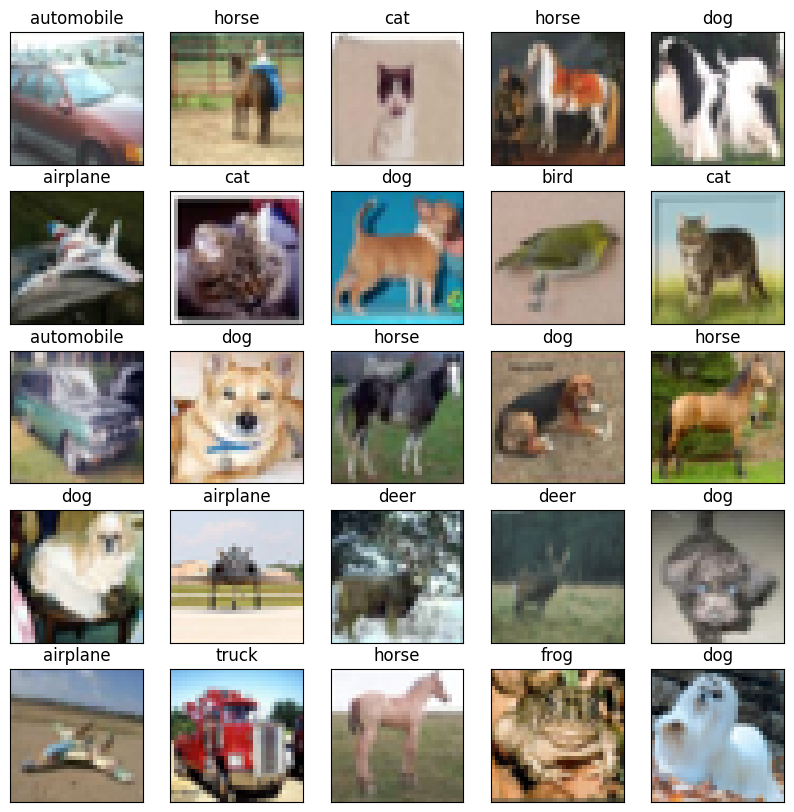

In [4]:
import matplotlib.pyplot as plt
import numpy as np

meta_data = unpickle(os.path.join(data_dir, 'batches.meta'))

# Sample images are selected from the first.
images = np.copy(training_batches[0][b'data'])
labels = training_batches[0][b'labels'].copy()
# Format the data accordingly.
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)

# 25 Sample images will appear in a square grid.
rows, columns = 5, 5
# List with 25 random image indices.
image_indices = np.random.randint(0, len(images), rows * columns)
# Their corresponding data. 
images = [images[i] for i in image_indices]
# Their corresponding labels. 
labels = [labels[i] for i in image_indices]

# Define figure
fig=plt.figure(figsize=(10, 10))
# Visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}".format(class_names[labels[i-1]].decode('utf-8')))
plt.show()

(Elapsed: 1.1s)

Now that we have loaded all the data, we will proceed to import sci-kit learn's `KNeighborsClassifier` and `NearestCentroid` classes.  
This way we will start to work towards the goal of the project. But first, we will format the data accordingly.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid


# data: a 10.000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image (1024 entries for each RGB channel).
print('Single Batch Training data dimensions: %dx%d' % np.shape(training_batches[0][b'data']))
# Format all target labels as a list of 50.000 entries. 
all_target_labels = np.copy(training_batches[0][b'labels'])
for i in range(1, 5):
    all_target_labels = np.concatenate((all_target_labels, training_batches[i][b'labels']), axis=0)
# Format all the training images as a 50.000x3072 numpy array.
all_training_data = np.copy(training_batches[0][b'data'])
for i in range(1, 5):
    all_training_data = np.concatenate((all_training_data, training_batches[i][b'data']), axis=0)

print('Unified Mega-Batch Training data dimensions: %dx%d' % np.shape(all_training_data))
print('Total training target labels: %d' % np.shape(all_target_labels))

# Total number of training samples
N_SAMPLES = np.shape(all_training_data)[0]
assert N_SAMPLES == np.shape(all_target_labels)[0]

# And the test data
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']

print('Total test data dimensions: %dx%d' % np.shape(test_data))
print('Total test target labels: %d' % np.shape(test_labels))

# Total number of test samples
N_TEST = np.shape(test_data)[0]
assert N_TEST == np.shape(test_labels)[0]

# Set to True if the training set should be shuffled.
RANDOMIZE = True

if RANDOMIZE:
    expanded_data = np.concatenate((all_training_data, np.reshape(all_target_labels, (N_SAMPLES, 1))), axis=1)
    np.random.shuffle(expanded_data)
    all_training_data = expanded_data[:,:-1]
    all_target_labels = expanded_data[:,-1]

Single Batch Training data dimensions: 10000x3072
Unified Mega-Batch Training data dimensions: 50000x3072
Total training target labels: 50000
Total test data dimensions: 10000x3072
Total test target labels: 10000


In [7]:
all_training_data

(Elapsed: 1.5s)

The following cell trains two **Nearest Neihgbors Classifiers** with k = 1 and k = 3 respectively, as well as a **Nearest Centroid Classifier**.  
All three of them use the *minkowski* distance with p = 2 as the default dissimilarity metric (equivalent to $l_2$ norm):
$$d_{p}(\,\overrightarrow{x}, \,\overrightarrow{y}\,) = \left(\sum_{i=1}^{n}|x_i - y_i|\right)^{1/p}$$

Finally the performance of each classifier is logged.

In [112]:
knn_1 = KNeighborsClassifier(n_jobs=-1, n_neighbors=1)
knn_3 = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
centr = NearestCentroid()

start = timer()
knn_1.fit(all_training_data, all_target_labels)
score = knn_1.score(test_data, test_labels)
stop =  timer()
print(f'[{stop - start:0.3f} sec] k = 1 Neighbors score: {100 * score:0.2f}%')
start = timer()
knn_3.fit(all_training_data, all_target_labels)
score = knn_3.score(test_data, test_labels)
stop = timer()
print(f'[{stop - start:0.3f} sec] k = 3 Neighbors score: {100 * score:0.2f}%')
start = timer()
centr.fit(all_training_data, all_target_labels)
score = centr.score(test_data, test_labels)
stop = timer()
print(f'[{stop - start:0.3f} sec] Nearest Centroids score: {100 * score:0.2f}%')

[23.822 sec] k = 1 Neighbors score: 35.39%
[24.064 sec] k = 3 Neighbors score: 33.03%
[0.403 sec] Nearest Centroids score: 27.74%


(Elapsed: 51.6s)

Below, there are some distinct, random classification examples extracted from the test set.

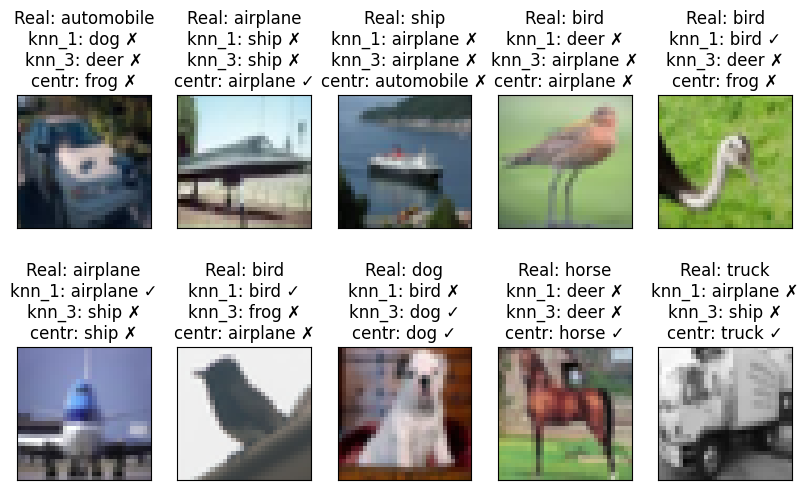

In [113]:
from random import sample

N_EXAMPLES = 10
index_list = sample(range(N_TEST), N_EXAMPLES)
example_objects = np.array([test_data[i] for i in index_list])
real_labels = np.array([test_labels[i] for i in index_list])

# Predicitons of each classifier
pred_k1 = knn_1.predict(example_objects)
pred_k3 = knn_3.predict(example_objects)
pred_nc = centr.predict(example_objects)

# Visual hints (ignore)
check = u'\u2713'
cross = u'\u2717'

# Visualize example images
fig=plt.figure(figsize=(10, 6))
for i in range(N_EXAMPLES):
    fig.add_subplot(2, N_EXAMPLES//2, i+1)
    example_img = np.copy(example_objects[i]).reshape(3, 32, 32).transpose(1, 2, 0)
    plt.imshow(example_img)
    plt.xticks([])
    plt.yticks([])
    plt.title(
        f"Real: {class_names[real_labels[i]].decode('utf-8')}\n"
        f"knn_1: {class_names[pred_k1[i]].decode('utf-8')} {check if real_labels[i] == pred_k1[i] else cross}\n"
        f"knn_3: {class_names[pred_k3[i]].decode('utf-8')} {check if real_labels[i] == pred_k3[i] else cross}\n"
        f"centr: {class_names[pred_nc[i]].decode('utf-8')} {check if real_labels[i] == pred_nc[i] else cross}"
        )
plt.show()

(Elapsed: 1.0s)

It is evident from the accuracy scores that the aforementioned methods do not perform well on the CIFAR-10 dataset.  
Although the nearest neighbors and nearest centroids algorithms are not as advanced as a neural network, most of the problem relies on the **dissimilarity metric**.  

Simply put, images are very abstract pieces of information.  
More specifically, the difference between corresponding pixels' RGB values has little to do with the **content** shown in the image.  
Other factors can greatly influence that difference such as:
* Lighting 
* Background color (e.g. grass or snow background)
* Color of examined object (e.g. white cat and black cat)
* Photographical angle of the object
* Distance of the object from the camera  

Thus, if we desire to classify images more accurately while avoiding to use neural networks, it is necessary that a more robust dissmilarity metric is used.  
One idea would be to use **Mahalanobis distance**. The Mahalanobis distance is considered a good distance metric for image classification problems.  
That is due to highly correlated features often contained in images (such as similarity in neighboring pixels) which the metric takes into account.

#### For Nearest Centroids:
$$d_{M}(\,\overrightarrow{x},\,C\,) = \sqrt{(\overrightarrow{x}-\overrightarrow{\mu})^{T}S^{-1}(\overrightarrow{x}-\overrightarrow{\mu})}$$
where $S$ the positive-definite covariance matrix of class $C$ and $\overrightarrow{\mu}$ the mean vector of class $C$.  
Specifically, we assign the test sample to the class with the smallest Mahalanobis distance (the class whose distribution it is most similar to).  
#### For K Nearest Neighbors:
$$d_{M}(\,\overrightarrow{x_{1}},\,\overrightarrow{x_{2}}\,;\,D) = \sqrt{(\overrightarrow{x_{1}}-\overrightarrow{x_{2}})^{T}S^{-1}(\overrightarrow{x_{1}}-\overrightarrow{x_{2}})}$$
where $S$ the positive-definite covariance matrix of the entire training dataset $D$ and $\overrightarrow{x_{1}}$, $\overrightarrow{x_{2}}$ two sample images.  

**Disadvantages:**
* The dataset's high dimensionality can make computing the covariance matrix computationally expensive.  
    1. Specifically, the calculation of matrix $S$ is of order $\mathcal{O}(m \cdot n^{2})$, where $n$ is the dimensionality of the data.  
    This happens 10 times, once for every class.  
    2. Also, the operation $(\overrightarrow{x}-\overrightarrow{\mu})^{T}S^{-1}(\overrightarrow{x}-\overrightarrow{\mu})$ is of order $\mathcal{O}(n^{2})$.  
    Doing this for the entire dataset of $m$ samples the order is $\mathcal{O}(m \cdot n^{2})$, which is prohibitive for $m = 50.000$ and $n = 3072$.
* `sklearn.neighbors.NearestCentroid` does not support the mahalanobis distance metric anymore, likely due to the aforementioned disadvantage.
* The Mahalanobis distance by itself still can't guarantee the best achievable accuracy.
* Danger of overfitting.

In [114]:
N_CLASSES = len(class_names)        # 10

# List of 10 numpy arrays. Each one contains all the training example of the same class.
samples_by_class = [[] for _ in range(N_CLASSES)]
# Mean value of each class.
mean_vectors = [None for _ in range(N_CLASSES)]
# Subtraction of the two aforementioned variables for each class.
centered_samples_by_class = [None for _ in range(N_CLASSES)]
# Covariance matrix of each class.
cov_matrices = [None for _ in range(N_CLASSES)]
# Inverse Covariance matrix of each class.
inv_cov_mat = [None for _ in range(N_CLASSES)]

for obj, label in zip(all_training_data, all_target_labels):
    samples_by_class[label].append(obj)

for i in range(N_CLASSES):
    # The CIFAR-10 websites mentions that there are 5000 instances of each class in the entire training set.
    samples_by_class[i] = np.concatenate(samples_by_class[i], axis=0).reshape(N_SAMPLES // N_CLASSES, 3072)
    mean_vectors[i] = np.mean(samples_by_class[i], axis=0)
    centered_samples_by_class[i] = np.subtract(
        samples_by_class[i], 
        np.repeat(
            np.reshape(
                np.copy(mean_vectors[i]), 
                (1, 3072)
            ), 
            repeats=[np.shape(samples_by_class[i])[0]], 
            axis=0
        )
    )
    X_c = centered_samples_by_class[i]
    cov_matrices[i] = (1 / np.shape(X_c)[0]) * np.matmul(np.transpose(X_c), X_c)
    inv_cov_mat[i] = np.linalg.inv(cov_matrices[i])

(Elapsed: 10.7s)

In [8]:
def mahalanobis(x: np.ndarray, label: int) -> float:
    x_minus_mu = np.reshape(np.subtract(x, mean_vectors[label]), (3072, 1))
    first_op = np.matmul(np.transpose(x_minus_mu), inv_cov_mat[label])
    second_op = np.matmul(first_op, x_minus_mu)
    val = second_op[0][0]
    return np.sqrt(val)


# Nearest Centroid Implementation
correctly_classified = 0
for instance, true_label in zip(test_data, test_labels):
    M = []
    for i in range(N_CLASSES):
        M.append(mahalanobis(instance, i))
    prediction = M.index(min(M))
    if prediction == true_label:
        correctly_classified += 1
print(f'Nearest Centroids (v.Mahalanobis) score = {100 * correctly_classified / len(test_labels)}%')

# K nearest neighbors was not implemented as the necassary time to execute it could not be afforded.
# ...

Nearest Centroids (v.Mahalanobis) score = 23.64%


(Elapsed: 5m, 31.5s)

It is evident that even when choosing a proper distance metric, there are still limitations in terms of accuracy and time complexity.  
This leads us to the last and most commonly accepted solution for image classification:  

#### **Dimensionality Reduction (D.R.)**
It greatly improves the performance in terms of **precision** and **complexity**
* **Precision:** High-dimensional data, such as our images, often contain noise or irrelevant information.  
    Dimensionality reduction can work as a <u>band-pass filter</u> and focus on the essential signal in the data, leading to more robust classification.
* **Complexity:** The demands in time and memory increases with the number of features in each sample.  
    By reducing the dimensionality of the data the computations are simplified and the training is sped up.  

### 1st Attempt at D.R.

As a first attempt to reduce the dimensions of the images, they will be converted to grayscale. Thus, the new images will be 3 times less in dimension.  
$$\overrightarrow{I}\in \{0,\,1,\,...,\,255\}^{3072}\;\rightarrow\;\overrightarrow{I'}\in \{0,\,1,\,...,\,255\}^{1024}$$
This strategy can be useful as, in this specific dataset, color is just noise and not an actual factor of what's displayed on the screen.  
The silhouette of an object should be sufficient (e.g. when distinguishing between a bird and a dog,  
but not between a blue and a yellow bird which isn't a problem in CIFAR-10).  

The grayscale value of each pixel is assigned the 

In [115]:
# Isolate the each RGB channel seperately for every entry
red = all_training_data[:,:1024]
green = all_training_data[:,1024:2048]
blue = all_training_data[:,2048:]

print('Original training data matrix:      %dx%d' % np.shape(all_training_data))
print('Red Channel training data matrix:   %dx%d' % np.shape(red))
print('Green Channel training data matrix: %dx%d' % np.shape(green))
print('Blue Channel training data matrix:  %dx%d' % np.shape(blue))

# Compute the grayscale value according to the formula of the weighted method, 
# also called the luminosity method, which weighs red, green, and blue according to their wavelengths..
# (The human eyes are most sensitive to green light, less sensitive to red light, and the least sensitive to blue light.)
gray_training_data = 0.299 * red + 0.587 * green + 0.114 * blue

print('Gray Channel training data matrix:  %dx%d' % np.shape(gray_training_data))

# Likewise, for the training data:
red = test_data[:,:1024]
green = test_data[:,1024:2048]
blue = test_data[:,2048:]

gray_test_data = 0.299 * red + 0.587 * green + 0.114 * blue


Original training data matrix:      50000x3072
Red Channel training data matrix:   50000x1024
Green Channel training data matrix: 50000x1024
Blue Channel training data matrix:  50000x1024
Gray Channel training data matrix:  50000x1024


(Elapsed: 0.8s)

Some random samples are projected to the screen. It is clear that the images are in black in white while preserving the information of their content.

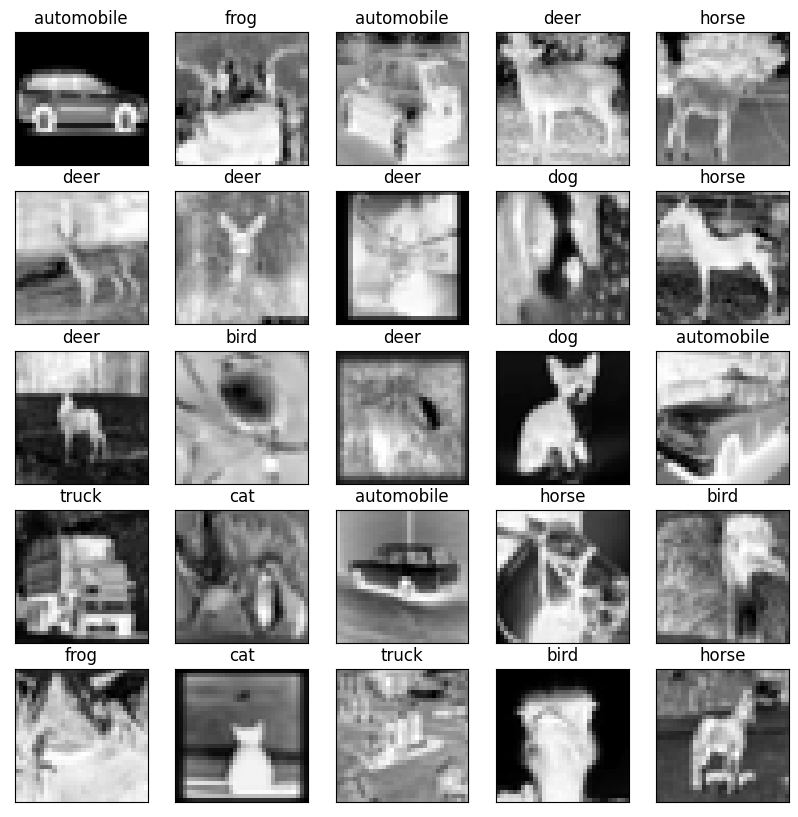

In [116]:
# Sample images are selected from the first.
images = np.copy(gray_training_data)
labels = np.copy(all_target_labels)
# Format the data accordingly.
images = images.reshape(len(images),1,32,32).transpose(0,2,3,1)

# 25 Sample images will appear in a square grid.
rows, columns = 5, 5
# List with 25 random image indices.
image_indices = np.random.randint(0, len(images), rows * columns)
# Their corresponding data. 
images = [images[i] for i in image_indices]
# Their corresponding labels. 
labels = [labels[i] for i in image_indices]

# Define figure
fig=plt.figure(figsize=(10, 10))
# Visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    # Images are shown in grayscale mode.
    plt.imshow(images[i-1], cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title("{}".format(class_names[labels[i-1]].decode('utf-8')))
plt.show()

(Elapsed: 0.6s)

Training and testing code is the same but the `KNeighborsClassifier`s and the `NearestCentroid` are trained and tested with the grayscale images.  
It is evident from the results that performance was affected slightly negatively in terms of accuracy (-5%) but positively in terms of elapsed time (+400% speedup).

In [117]:
knn_1 = KNeighborsClassifier(n_jobs=-1, n_neighbors=1)
knn_3 = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
centr = NearestCentroid()

start = timer()
knn_1.fit(gray_training_data, all_target_labels)
score = knn_1.score(gray_test_data, test_labels)
stop =  timer()
print(f'[{stop - start:0.3f} sec] k = 1 Neighbors score: {100 * score:0.2f}%')
start = timer()
knn_3.fit(gray_training_data, all_target_labels)
score = knn_3.score(gray_test_data, test_labels)
stop = timer()
print(f'[{stop - start:0.3f} sec] k = 3 Neighbors score: {100 * score:0.2f}%')
start = timer()
centr.fit(gray_training_data, all_target_labels)
score = centr.score(gray_test_data, test_labels)
stop = timer()
print(f'[{stop - start:0.3f} sec] Nearest Centroids score: {100 * score:0.2f}%')

[4.833 sec] k = 1 Neighbors score: 30.18%
[5.005 sec] k = 3 Neighbors score: 27.93%
[0.215 sec] Nearest Centroids score: 24.12%


(Elapsed: 10.0s)

### 2nd Attempt at D.R.

A more sophisticated D.R. technique that should improve the results is **Principal Component Analysis** (PCA).  
PCA is a widely used technique for reducing the dimensionality of a dataset while preserving as much of the relevant information as possible.  

In [124]:
from sklearn.decomposition import PCA

# The following PCA model reduces the dimensionality of the input data, 
# preseving only the n = 30, 50, 100, 300, 500 most significant input values.
for n in [30, 50, 100, 300, 500]:
    print(f'Reducing images to {n} dimensions:')
    pca = PCA(n_components=n)
    # Model is fitted to the CIFAR-10 dataset
    pca.fit(all_training_data)
    # 3072-n least significant input variables are discarded.
    reduced_training_data = pca.transform(all_training_data)
    reduced_test_data = pca.transform(test_data)

    knn_1 = KNeighborsClassifier(n_jobs=-1, n_neighbors=1)
    knn_3 = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
    centr = NearestCentroid()

    start = timer()
    knn_1.fit(reduced_training_data, all_target_labels)
    score = knn_1.score(reduced_test_data, test_labels)
    stop =  timer()
    print(f'- [{stop - start:0.3f} sec] k = 1 Neighbors score: {100 * score:0.2f}%')
    start = timer()
    knn_3.fit(reduced_training_data, all_target_labels)
    score = knn_3.score(reduced_test_data, test_labels)
    stop = timer()
    print(f'- [{stop - start:0.3f} sec] k = 3 Neighbors score: {100 * score:0.2f}%')
    start = timer()
    centr.fit(reduced_training_data, all_target_labels)
    score = centr.score(reduced_test_data, test_labels)
    stop = timer()
    print(f'- [{stop - start:0.3f} sec] Nearest Centroids score: {100 * score:0.2f}%')
    print()

Reducing images to 30 dimensions:
- [0.645 sec] k = 1 Neighbors score: 38.93%
- [0.651 sec] k = 3 Neighbors score: 38.34%
- [0.019 sec] Nearest Centroids score: 27.62%

Reducing images to 50 dimensions:
- [0.654 sec] k = 1 Neighbors score: 39.16%
- [0.796 sec] k = 3 Neighbors score: 37.68%
- [0.025 sec] Nearest Centroids score: 27.59%

Reducing images to 100 dimensions:
- [0.866 sec] k = 1 Neighbors score: 38.61%
- [0.911 sec] k = 3 Neighbors score: 36.77%
- [0.035 sec] Nearest Centroids score: 27.66%

Reducing images to 300 dimensions:
- [1.637 sec] k = 1 Neighbors score: 36.90%
- [1.750 sec] k = 3 Neighbors score: 34.49%
- [0.075 sec] Nearest Centroids score: 27.73%

Reducing images to 500 dimensions:
- [2.380 sec] k = 1 Neighbors score: 36.30%
- [2.379 sec] k = 3 Neighbors score: 33.71%
- [0.112 sec] Nearest Centroids score: 27.74%



(Elapsed: 1m, 57.3s)

In [125]:
# Same process but for the grayscale data.
for n in [30, 50, 100, 300, 500]:
    print(f'Reducing images to {n} dimensions:')
    pca = PCA(n_components=n)
    pca.fit(gray_training_data)
    reduced_training_data = pca.transform(gray_training_data)
    reduced_test_data = pca.transform(gray_test_data)

    knn_1 = KNeighborsClassifier(n_jobs=-1, n_neighbors=1)
    knn_3 = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
    centr = NearestCentroid()

    start = timer()
    knn_1.fit(reduced_training_data, all_target_labels)
    score = knn_1.score(reduced_test_data, test_labels)
    stop =  timer()
    print(f'- [{stop - start:0.3f} sec] k = 1 Neighbors score: {100 * score:0.2f}%')
    start = timer()
    knn_3.fit(reduced_training_data, all_target_labels)
    score = knn_3.score(reduced_test_data, test_labels)
    stop = timer()
    print(f'- [{stop - start:0.3f} sec] k = 3 Neighbors score: {100 * score:0.2f}%')
    start = timer()
    centr.fit(reduced_training_data, all_target_labels)
    score = centr.score(reduced_test_data, test_labels)
    stop = timer()
    print(f'- [{stop - start:0.3f} sec] Nearest Centroids score: {100 * score:0.2f}%')
    print()

Reducing images to 30 dimensions:
- [0.625 sec] k = 1 Neighbors score: 34.39%
- [0.750 sec] k = 3 Neighbors score: 33.36%
- [0.020 sec] Nearest Centroids score: 24.17%

Reducing images to 50 dimensions:
- [0.719 sec] k = 1 Neighbors score: 34.66%
- [0.858 sec] k = 3 Neighbors score: 33.00%
- [0.025 sec] Nearest Centroids score: 24.17%

Reducing images to 100 dimensions:
- [0.983 sec] k = 1 Neighbors score: 33.45%
- [0.982 sec] k = 3 Neighbors score: 31.35%
- [0.036 sec] Nearest Centroids score: 24.17%

Reducing images to 300 dimensions:
- [1.716 sec] k = 1 Neighbors score: 31.04%
- [1.806 sec] k = 3 Neighbors score: 28.79%
- [0.077 sec] Nearest Centroids score: 24.13%

Reducing images to 500 dimensions:
- [2.573 sec] k = 1 Neighbors score: 30.51%
- [2.538 sec] k = 3 Neighbors score: 28.35%
- [0.118 sec] Nearest Centroids score: 24.13%



(Elapsed: 52.7s)

### **Conclusion**  
Two points are evident:
1.  In every scenario the **K Nearest Neighbors** algorithm performs better than the **Nearest Centroid** algorithm in terms of accuracy  
    but takes substantially more time to finish. One major reason that KNN is slower is that it requires directly observing the training data elements at evaluation time. More specifically, in order to make a single prediction a naive KNN classifier has to:  
    * Evaluate the distance between the given point and **all** the points of the training set.
    * Sort these distances.  

    On the other hand, `NearestCentroid` is a model that computes all necessary variables for prediction during training (the centroid of each class).  
    This way its demands in time are significantly lower.  
    
    `KNearestCentroid`'s ability to solve nonlinear problems in low dimensional spaces with such simplicity is incredible, but runtime (and performance)  
    on larger and high dimensional problems is certainly a downside. The performance breaks down in high dimensional spaces because distance between  
    points becomes less meaningful of a quantity (curse of dimensionality and knn).   

2.  There seems to be no significant improvement to these models regardless of the distance metrics used and the transformations applied to the data.  
    The models' accuracies do not exceed 40%. That is justified because, as it was mentioned earlier, images are very abstract pieces of information.  
    Analyzing visual images, recognizing patters and thus understanding their content is an advanced cognitive process.  
    Simple mathematical algorithms used in statistics such as the two aforementioned ones are expected to have some success, but we should have low  
    expectations while looking for optimality.